# 📈 Project: Marketing Analysis and Expense Optimization (Y.Afisha)

## Main Objective

Optimize Y.Afisha's marketing expenses by analyzing customer behavior. The goal is to understand the user journey and the value each customer brings to the company, determining the **return on investment (ROI)** and the **payback period**.

## Available Data

The analysis will be based on data from **January 2017 to December 2018**:

* **Server Logs:** Y.Afisha access data (usage behavior).
* **Dump File (Orders):** All orders and transactions made during the period.
* **Marketing Statistics:** Detailed expenses by channel/campaign.

## Analysis Scope

The project will focus on four key areas:

1.  **Product Usage:** How and when users access the product.
2.  **Purchase Cycle:** When users make their first purchase after initial access.
3.  **Cohort Analysis and LTV:** How much money each customer brings to the company over time (Lifetime Value).
4.  **Expense Optimization:** Calculation of Customer Acquisition Cost (CAC) and determination of when marketing expenses will be covered.

# 1. Data Loading and Preprocessing

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [136]:
# Importing Data
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

In [137]:
# Data Sample Inspection
print(visits.head())
print(orders.head())
print(costs.head())

    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  
                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450
   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06

In [138]:
# Standardize Column Names (snake_case) 
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']
costs.columns = ['source_id', 'dt', 'costs']


In [139]:
# Convert Date Columns to Datetime
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [140]:
# Verify Data Types
print(visits.info())
print(orders.info())
print(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entri

In [141]:
# Check for Missing Values
print(visits.isnull().sum())
print(orders.isnull().sum())
print(costs.isnull().sum())

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64
buy_ts     0
revenue    0
uid        0
dtype: int64
source_id    0
dt           0
costs        0
dtype: int64


# 2. Reporting and Metric Calculation

# 2.1 Product  

In [142]:
# Create Rounded Date Columns
visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.to_period('W').apply(lambda r: r.start_time)
visits['month'] = visits['start_ts'].dt.to_period('M').astype(str)

In [143]:
# Unique Users by Day, Week, and Month
users_daily = visits.groupby('date')['uid'].nunique()
users_weekly = visits.groupby('week')['uid'].nunique()
users_monthly = visits.groupby('month')['uid'].nunique()

In [144]:
# Visualize Results
print("Unique users by day:")
print(users_daily.head())

print("\nUnique users by week:")
print(users_weekly.head())

print("\nUnique users by month:")
print(users_monthly.head())



Usuários únicos por dia:
date
2017-06-01    605
2017-06-02    608
2017-06-03    445
2017-06-04    476
2017-06-05    820
Name: uid, dtype: int64

Usuários únicos por semana:
week
2017-05-29    2021
2017-06-05    4129
2017-06-12    2812
2017-06-19    2878
2017-06-26    3064
Name: uid, dtype: int64

Usuários únicos por mês:
month
2017-06    13259
2017-07    14183
2017-08    11631
2017-09    18975
2017-10    29692
Name: uid, dtype: int64


In [145]:
# Each Row Represents One Session (Visit) 
sessions_per_day = visits.groupby('date')['uid'].count()

print("Daily Session Count:")
print(sessions_per_day.head())

Número de sessões por dia:
date
2017-06-01    664
2017-06-02    658
2017-06-03    477
2017-06-04    510
2017-06-05    893
Name: uid, dtype: int64


In [146]:
# Calculate Session Duration (Seconds and Minutes)
visits['session_duration_min'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds() / 60

In [147]:
# Display Descriptive Statistics
print("Session Duration in Minutes:")
print(visits['session_duration_min'].describe())

Duração das sessões (minutos):
count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration_min, dtype: float64


In [148]:
# Sort by User and Visit Date
visits_sorted = visits.sort_values(by=['uid', 'start_ts'])

In [149]:
# Calculate Time Between Consecutive Visits 
visits_sorted['prev_session'] = visits_sorted.groupby('uid')['start_ts'].shift()
visits_sorted['days_between_visits'] = (visits_sorted['start_ts'] - visits_sorted['prev_session']).dt.days

In [150]:
# Visualize Average Inter-Visit Time 
print("Average Inter-Visit Time (in Days):")
print(visits_sorted['days_between_visits'].mean())

Intervalo médio entre visitas (em dias):
27.67683702783641


Conclusion: Product Usage Analysis
Key Findings:

Good daily session volume.

Quick interactions (short session duration).

Returning user behavior that can be leveraged for re-engagement strategies.

These initial metrics help us understand how the product is used, creating a solid foundation for decisions regarding marketing, product improvements, and retention efforts.



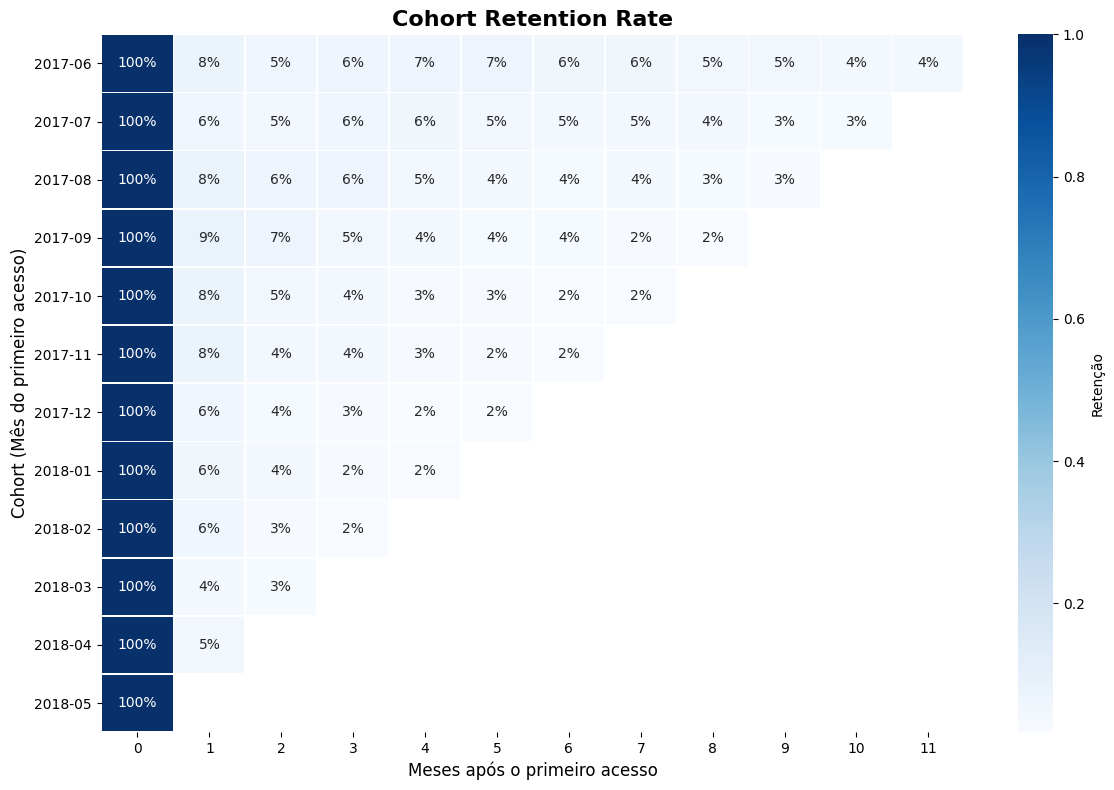

In [151]:
# Prepare Data for Cohort Analysis
visits['month'] = visits['start_ts'].dt.to_period('M')
first_month = visits.groupby('uid')['month'].min().reset_index()
first_month.columns = ['uid', 'first_month']
df_visits = visits.merge(first_month, on='uid')
df_visits['lifetime'] = (df_visits['month'] - df_visits['first_month']).apply(lambda x: x.n)

# Calculate Cohort Retention
cohort = df_visits.groupby(['first_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()
initial_users = cohort[cohort['lifetime'] == 0][['first_month', 'uid']].rename(columns={'uid': 'users'})
cohort = cohort.merge(initial_users, on='first_month')
cohort['retention'] = cohort['uid'] / cohort['users']

# Create the Retention Matrix 
retention_pivot = cohort.pivot_table(index='first_month', columns='lifetime', values='retention', aggfunc='sum')

# Visualize with Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    retention_pivot,
    annot=True,
    fmt='.0%',
    cmap='Blues',
    linewidths=0.5,
    cbar_kws={'label': 'Retenção'}
)
plt.title('Cohort Retention Rate', fontsize=16, weight='bold')
plt.xlabel('Months Since First Access', fontsize=12)
plt.ylabel('Acquisition Cohort (Month)', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2.2 Sales

In [152]:
# Get User's First Visit Date
first_visits = visits.groupby('uid')['start_ts'].min().reset_index()
first_visits.columns = ['uid', 'first_visit_date']

In [153]:
# Get User's First Purchase Date
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid', 'first_order_date']


In [154]:
# Merge First Visit and Purchase Dates
conversion = pd.merge(first_visits, first_orders, on='uid')

In [155]:
# Calculate Time to First Purchase
conversion['conversion_days'] = (conversion['first_order_date'] - conversion['first_visit_date']).dt.days

In [156]:
# Distribution of Days to Conversion 
print("Distribution of Days to First Purchase:")
print(conversion['conversion_days'].value_counts().sort_index())

# Display Overall Statistics
print("\nGeneral Statistics for Time to Conversion:")
print(conversion['conversion_days'].describe())


Distribuição de dias até a primeira compra:
0      26363
1       1011
2        563
3        434
4        324
       ...  
354        1
355        3
357        4
362        1
363        1
Name: conversion_days, Length: 345, dtype: int64

Estatísticas gerais de tempo até conversão:
count    36523.000000
mean        16.729869
std         46.959088
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: conversion_days, dtype: float64


In [157]:
# Number of Orders Per User
orders_per_user = orders.groupby('uid').size()

In [158]:
# Descriptive Statistics
print("Orders per User:")
print(orders_per_user.describe())

Pedidos por cliente:
count    36523.000000
mean         1.380363
std          3.454461
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        239.000000
dtype: float64


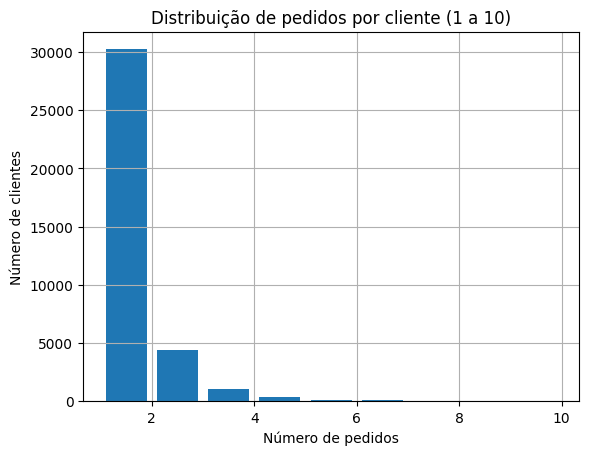

In [159]:
# Plot Histogram

orders_per_user.plot(kind='hist', bins=range(1, 11), rwidth=0.8)
plt.title('Distribution of Orders Per Customer (1 a 10)')
plt.xlabel('Total Number of Orders')
plt.ylabel('Customer Count')
plt.grid(True)
plt.show()

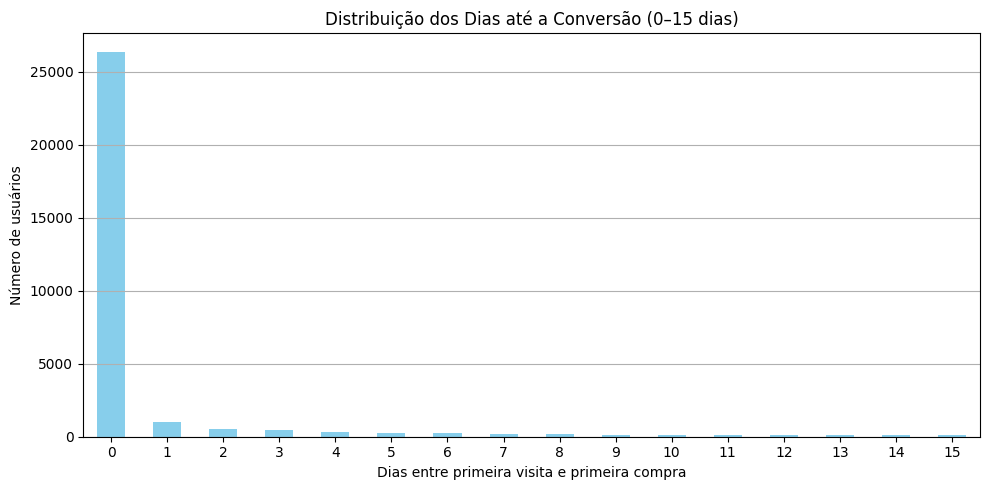

In [160]:
# Filter for First 15 Days of Conversion
conversion_counts = conversion['conversion_days'].value_counts().sort_index()
conversion_counts = conversion_counts[conversion_counts.index <= 15]

# New Chart Focusing on Initial Days 
plt.figure(figsize=(10, 5))
conversion_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Days to Conversion  (0–15 dias)')
plt.xlabel('Days Between First Visit and First Purchase')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [161]:
# Statistics on Order Value
print("Order Value Descriptive Statistics:")
print(orders['revenue'].describe())


Estatísticas do valor por compra:
count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64


The graph shows that the September 2017 cohort had the highest accumulated LTV, reaching R$13.44 after 11 months. This indicates that the customers acquired during this period were the most valuable over time. More recent cohorts have not yet had enough time to accumulate a high LTV.


In [166]:
# Overall Lifetime Value (LTV) Metrics
print("\nUser Total Revenue Metrics:")
print(revenue_per_user.describe())


Estatísticas de receita total por usuário:
count    36523.000000
mean         6.901328
std         88.128535
min          0.000000
25%          1.470000
50%          3.050000
75%          5.800000
max      11810.180000
Name: revenue, dtype: float64


Sales analysis showed that the majority of users make their first purchase on the same day they first visit the website, indicating quick and effective conversion right at the first contact with the product. This is visible in the daily conversion graph, which shows a sharp peak in the initial days and a progressive decline thereafter. This suggests that the initial experience is efficient, but there is an opportunity to stimulate delayed conversions. Regarding order frequency, almost all customers made only one purchase, which reveals a pattern of one-time use and low recurrence. Furthermore, the average order value is relatively low. Since most customers do not place new orders, the LTV (Lifetime Value) also remains low, reinforcing the importance of retention and loyalty strategies to increase both the frequency and the value of purchases over time.



# 2.3 Marketing and ROI Analysis

In [167]:
Total Marketing Spend
total_cost = costs['costs'].sum()
print(f"Total Marketing Spend: ${total_cost:.2f}")

Gasto total em marketing: $329131.62


In [168]:
# Costs by Ad Source (source_id)
costs_by_source = costs.groupby('source_id')['costs'].sum()
print("\n# Costs by Ad Source:")
print(costs_by_source)


Gastos por origem de anúncio:
source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64


In [169]:
# Marketing Spend Over Time (Monthly)
costs['month'] = costs['dt'].dt.to_period('M')
costs_by_month = costs.groupby('month')['costs'].sum()

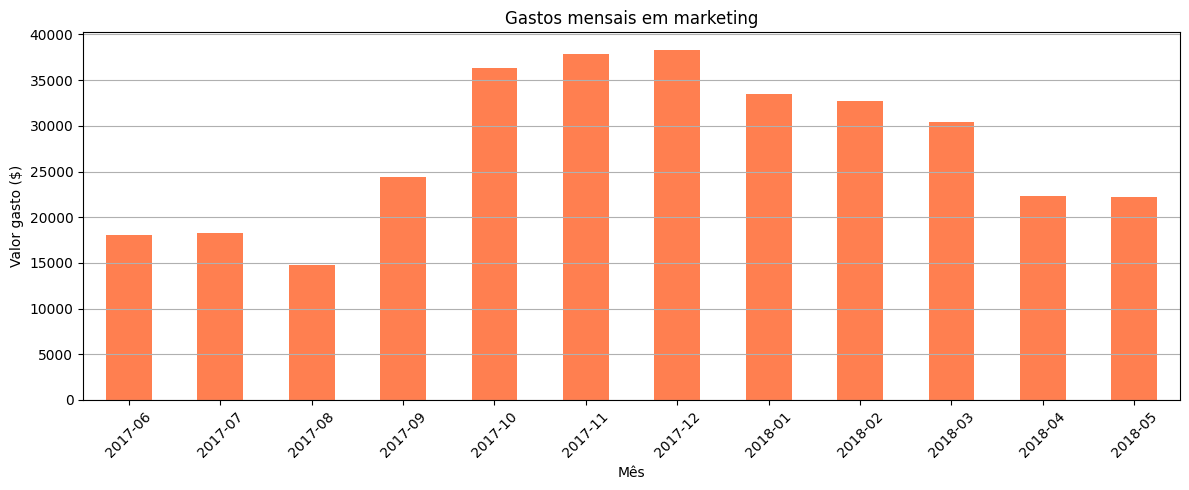

In [170]:
# Chart: Monthly Marketing Spend 
costs_by_month.plot(kind='bar', figsize=(12,5), title='Gastos mensais em marketing# Chart: Monthly Marketing Spend ', color='coral')
plt.ylabel('Amount Spent ($)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The bar represents the total amount invested in marketing each month (summing all channels).
The chart helps visualize peaks in investment and periods with lower spending.

Conclusion: The chart shows that marketing spending increased significantly at the end of 2017, peaking between October and December. Starting in 2018, investments began to fall gradually. This may indicate an intense acquisition campaign at the end of the year, followed by a strategic reduction in subsequent months.



In [171]:
# Determine Acquisition Month and Source per User
first_visits = visits.groupby('uid').agg({'start_ts': 'min', 'source_id': 'first'})
first_visits['month'] = first_visits['start_ts'].dt.to_period('M')

In [172]:
# New Users by Source and Month
new_users = first_visits.groupby(['source_id', 'month']).size().reset_index(name='new_users')


In [173]:
# Spend by Source and Month
monthly_costs = costs.groupby(['source_id', 'month'])['costs'].sum().reset_index()


In [174]:
# Combine Acquisition and Marketing Spend Data
cac = pd.merge(monthly_costs, new_users, on=['source_id', 'month'], how='left')
cac['cac'] = cac['costs'] / cac['new_users']

In [175]:
# View Results
print("\nCustomer Acquisition Cost (CAC) by Source and Month(CAC):")
print(cac[['source_id', 'month', 'cac']].dropna().head())


Custo de aquisição por origem e mês (CAC):
   source_id    month       cac
0          1  2017-06  1.475242
1          1  2017-07  1.545937
2          1  2017-08  2.016547
3          1  2017-09  1.748556
4          1  2017-10  1.827743


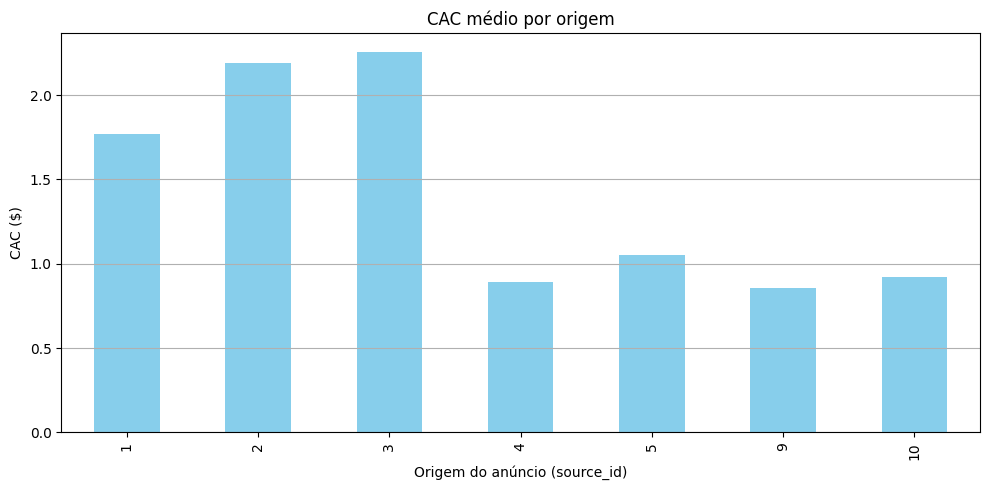

In [176]:
# Chart: Average CAC by Source
avg_cac_by_source = cac.groupby('source_id')['cac'].mean()
avg_cac_by_source.plot(kind='bar', figsize=(10,5), title='Average CAC by Source ', color='skyblue')
plt.ylabel('CAC ($)')
plt.xlabel('Source ID')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The chart displays the Average Customer Acquisition Cost (CAC) for each ad source (source_id). It reveals how much, on average, was spent to acquire a single customer through each marketing channel.

Some ad sources are much more efficient than others. Channels with IDs 4, 9, and 10 acquired customers at a lower cost, while channels 2 and 3 had a higher CAC, which could compromise profitability if the Lifetime Value (LTV) doesn't compensate.

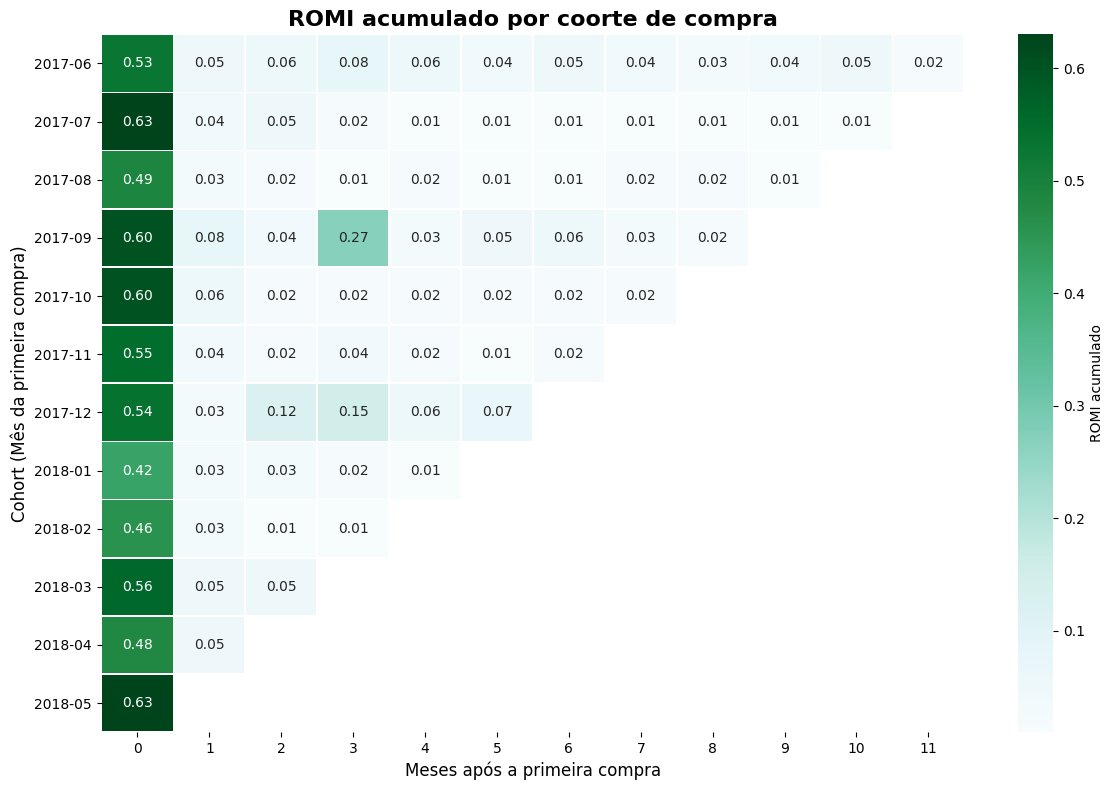

In [178]:
# Create Column for Purchase Month 
orders['order_month'] = orders['buy_ts'].dt.to_period('M')

# Identify User's First Purchase Month
first_order_month = orders.groupby('uid')['order_month'].min().reset_index().rename(columns={'order_month': 'first_order_month'})

# Merge with Orders DataFrame
cohorts = pd.merge(orders, first_order_month, on='uid')

# Calculate Cohort Lifetime (Time Since Acquisition)
cohorts['cohort_lifetime'] = (cohorts['order_month'] - cohorts['first_order_month']).apply(lambda x: x.n)

# Group Revenue and Buyers by Cohort and Month 
cohorts_agg = cohorts.groupby(['first_order_month', 'order_month']).agg(
    revenue=('revenue', 'sum'),
    n_buyers=('uid', 'nunique')
).reset_index()

# Recalculate Cohort Lifetime 
cohorts_agg['cohort_lifetime'] = (cohorts_agg['order_month'] - cohorts_agg['first_order_month']).apply(lambda x: x.n)

# Prepare Monthly Cost Data 
costs['costs_month'] = costs['dt'].dt.to_period('M')
monthly_costs = costs.groupby('costs_month').agg(costs=('costs', 'sum')).reset_index()

# Merge Costs with Cohort Data
cohorts_agg = pd.merge(cohorts_agg, monthly_costs, left_on='order_month', right_on='costs_month', how='left')

# Calculate CAC, LTV, and ROMI (
cohorts_agg['cac'] = cohorts_agg['costs'] / cohorts_agg['n_buyers']
cohorts_agg['ltv'] = cohorts_agg['revenue'] / cohorts_agg['n_buyers']
cohorts_agg['romi'] = cohorts_agg['ltv'] / cohorts_agg['cac']

# Create Pivot Table with ROMI
romi_pivot = cohorts_agg.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='romi',
    aggfunc='mean'
).round(2)

# Visualize ROMI with Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    romi_pivot,
    annot=True,
    fmt='.2f',
    cmap='BuGn',
    linewidths=0.5,
    cbar_kws={'label': 'ROMI acumulado'}
)

plt.title('Accumulated ROMI by Purchase Cohort', fontsize=16, weight='bold')
plt.xlabel('Cohort Lifetime (in Months)', fontsize=12)
plt.ylabel('Cohort (Month of First Purchase) ', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The chart shows that most of the Return on Marketing Investment (ROMI) occurs right in the first month after customer acquisition, especially for the July 2017 and May 2018 cohorts, with initial values up to 0.63. Overall, the accumulated ROMI tends to grow very little over time, indicating that the financial return from marketing campaigns is concentrated at the beginning of the customer journey.



# 3. Conclusion

# Project Conclusion

Based on the analysis of marketing, user behavior, and sales performance, we were able to identify which channels and strategies delivered the best results for the business.

---

### Investment Recommendations

By analyzing **CAC (Customer Acquisition Cost)** and **ROI (Return on Investment)**, the most recommended channels are:

* **Source ID 1:** Showed the **highest ROI (above 1.2)**, indicating that every dollar invested generated more than double the revenue. Although not the cheapest CAC, it was the most profitable channel.
* **Source ID 9:** Had one of the **lowest CACs** and a **positive ROI**, making it an efficient, low-risk option.

Channels like **Source 3 and 10**, however, generated a **negative ROI** and should be avoided, even though they had moderate or low CAC.

---

### Key Metrics Used for Decision-Making

* **CAC** identified the most expensive or cheapest channels to acquire customers but was not used in isolation.
* **ROI** was the main metric used to assess the return on investment.
* **Average Revenue per Device** showed that **desktop users generate more revenue** than mobile users, which may influence segmentation decisions.
* **LTV per Cohort** highlighted that the majority of customers make only one purchase, with little value growth over the months.
* **ROMI per Cohort** confirmed that the return on investment occurs mainly in the first month post-acquisition, with low cumulative growth.

---

### Overall Conclusion

Most marketing spending occurred between October and December 2017. However, only a few channels provided a positive return, reinforcing the importance of constantly monitoring channel-specific metrics. The recommendation is to **focus investments on channels with proven positive ROI**, such as **Source 1 and 9**, and to rethink channels with unsatisfactory performance.

Furthermore, since the repurchase rate is low and **LTV does not grow significantly over time**, **loyalty and retention initiatives** must be a priority to increase future profitability.

---